<a href="https://colab.research.google.com/github/adnaks97/Natural-Language-Inference/blob/master/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 1.3MB 10.8MB/s 
     |████████████████████████████████| 890kB 59.5MB/s 
     |████████████████████████████████| 2.9MB 53.2MB/s 
     |████████████████████████████████| 1.1MB 51.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=9ebbd4c16d597b63dc3daa70054a8329ff6152d4286ca64620f12546bf7d9957
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
from google.colab import drive
import os
from getpass import getpass
import urllib
drive.mount('/content/drive')
# If repo already cloned in drive
os.chdir('drive/My Drive/Natural-Language-Inference')

# If not cloned yet
# os.chdir('drive/My Drive/

Mounted at /content/drive


In [20]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer, AdamW, BertForSequenceClassification, BertTokenizer
import torch.nn.functional as F
from torch import nn

In [21]:
def extract_sentences(df):
  pre, hyp, labels = df['premise'].tolist(), df['hypothesis'].tolist(), df['gold_label'].tolist()
  return pre, hyp, labels

In [22]:
BATCH_SIZE = 16
LR = '5e5'
model_name = "emilyalsentzer/Bio_ClinicalBERT" #'gsarti/scibert-nli' #'gsarti/biobert-nli' #  # # #'gsarti/scibert-nli' # #'gsarti/scibert-nli' # #'bert-base-uncased' 

In [23]:
model_folder_name = './results/{}-{}-{}'.format(model_name.split('/')[1], LR, BATCH_SIZE)
model_save_name = '{}_bs{}_lr{}.ckpt'.format(model_name.split('/')[1], BATCH_SIZE, LR)
SAVE_PATH = os.path.join(model_folder_name, model_save_name) #'checkpoint-1400')#
SAVE_PATH = './results/Bio_ClinicalBert_bs16_lrDEF.ckpt'
SAVE_PATH

'./results/Bio_ClinicalBert_bs16_lrDEF.ckpt'

In [24]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(SAVE_PATH, force_download=True)

In [26]:
test_df = pd.read_csv('Data/mli_test_v1.csv')
test_pre, test_hyp, test_labels = extract_sentences(test_df)
test_encodings = tokenizer(test_pre, test_hyp, padding=True)
le = LabelEncoder()
le.fit(test_labels)
test_labels = le.transform(test_labels)
le.classes_

array(['contradiction', 'entailment', 'neutral'], dtype='<U13')

In [27]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

In [28]:
from torch.utils.data import Dataset, DataLoader

class MedNLIDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels
  
  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

In [31]:
test_dataset = MedNLIDataset(test_encodings, test_labels)

In [32]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [33]:
loss_fn = torch.nn.CrossEntropyLoss()

In [34]:
class MyTrainer(Trainer):
  def compute_loss(self, model, inputs):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs[0]
    #print(labels)
    #print(logits.shape)
    return loss_fn(logits, labels)

In [35]:
tester = MyTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    compute_metrics=compute_metrics
)


In [36]:
preds = tester.predict(test_dataset=test_dataset)

In [37]:
preds.metrics

{'eval_accuracy': 0.8263009845288326,
 'eval_f1': 0.8264788090928512,
 'eval_loss': 0.7574371099472046,
 'eval_precision': 0.8267219226746492,
 'eval_recall': 0.8263009845288326}

In [42]:
def make_error_report(preds, test_pre, test_hyp, le, fname):
  """
  :param: preds - preds from trainer.predict()
  :param: test_pre - test premise sentences - list
  :param: test_hyp - test hypothesis sentences - list
  :param: le - LabelEncoder fitted on dataset
  :param: fname - file name
  returns:
    df - dataframe of error report
  """

  fname = fname.split('/')[-1].split('.')[0] + '.csv'
  model_preds = preds.predictions.argmax(-1)
  ground_truth = preds.label_ids
  inds = np.where(model_preds != ground_truth)[0]

  pre = np.array(test_pre)[inds]
  hyp = np.array(test_hyp)[inds]
  error_preds = le.inverse_transform(model_preds[inds])
  gold_label = le.inverse_transform(ground_truth[inds])

  df = pd.DataFrame({'premise': pre, 'hypothesis': hyp, 'error_label': error_preds, 'gold_label': gold_label})
  save_loc = os.path.join('error_analysis', fname)
  df.to_csv(save_loc)
  return df

In [48]:
error_df = make_error_report(fname='./results/Bio_ClinicalBert_bs16_lr3e5.ckpt', preds=preds, test_pre=test_pre, test_hyp=test_hyp, le=le)

array([[407,  42,  25],
       [ 29, 381,  64],
       [ 30,  57, 387]])

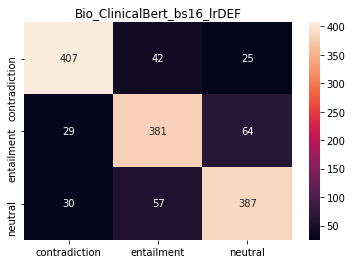

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
save_name = SAVE_PATH.split('/')[-1].split('.')[0]
cm = confusion_matrix(preds.label_ids, preds.predictions.argmax(-1))
ax = plt.axes()
ax.set_title(save_name)
plt.xlabel('Ground truth label')
plt.ylabel('Predicted label')
sns.heatmap(cm, annot=True, yticklabels=le.classes_, xticklabels=le.classes_, ax=ax, fmt='g')
plt.savefig('./plots/{}.png'.format(save_name))
cm

In [39]:
np.save('ensemble/{}.npy'.format(save_name), preds.predictions)

In [23]:
np.save('ensemble/labels.npy'.format(save_name), preds.label_ids)

In [40]:
bioCli, bio, sci = np.load('ensemble/Bio_ClinicalBert_bs16_lrDEF.npy'), np.load('ensemble/biobert-nli_bs16_lrDEF.npy'), np.load('ensemble/scibert-nli_bs16_lr5e5.npy')

In [53]:
ensemble_preds = (2*bioCli + 0.5*bio + 0.5*sci) / 3.0

In [54]:
labels = preds.label_ids

In [55]:
precision, recall, f1, _ = precision_recall_fscore_support(labels, ensemble_preds.argmax(-1), average='weighted')
acc = accuracy_score(labels, ensemble_preds.argmax(-1))
ensemble_metrics = {
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}

In [56]:
ensemble_metrics

{'accuracy': 0.8270042194092827,
 'f1': 0.8269943445430107,
 'precision': 0.8269929319364352,
 'recall': 0.8270042194092827}

array([[418,  32,  24],
       [ 30, 382,  62],
       [ 32,  59, 383]])

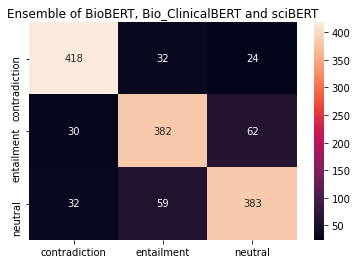

In [48]:
cm_ensemble = confusion_matrix(preds.label_ids, ensemble_preds.argmax(-1))
ax = plt.axes()
ax.set_title('Ensemble of BioBERT, Bio_ClinicalBERT and sciBERT')
plt.xlabel('Ground truth label')
plt.ylabel('Predicted label')
sns.heatmap(cm_ensemble, annot=True, yticklabels=le.classes_, xticklabels=le.classes_, ax=ax, fmt='g')
plt.savefig('./plots/{}.png'.format('ensemble'))
cm_ensemble